### Imports

In [4]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torchvision.transforms as T
from torchvision.models.detection import fasterrcnn_resnet50_fpn

from PIL import ImageGrab, Image
import time
from ipywidgets import Button, widgets
from IPython.display import display, clear_output
import threading
import subprocess

import pygetwindow as gw

### Get Image Testing Data

In [ ]:
def load_images_from_directory(directory, target_size=(1024, 1024)):
    images = []
    filenames = []
    for filename in os.listdir(directory):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff')):
            img = cv2.imread(os.path.join(directory, filename))
            if img is not None:
                # Resize image to target size
                img = cv2.resize(img, target_size)
                # Convert to RGB if the image is grayscale
                if len(img.shape) == 2:
                    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
                images.append(img)
                filenames.append(filename)
    return np.array(images), filenames

# Load images and filenames
directory = 'data'
images, filenames = load_images_from_directory(directory)

# Convert to DataFrame if needed
df = pd.DataFrame({'filename': filenames, 'image': list(images)})

### Display Raw Images

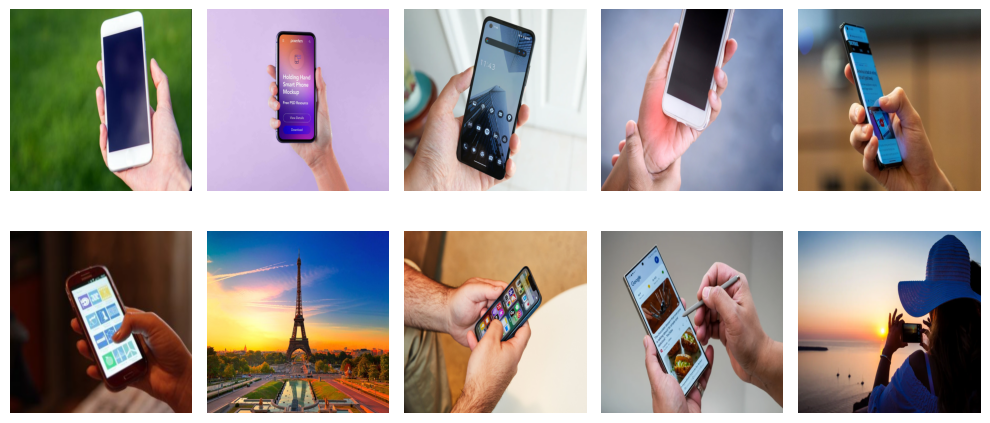

In [ ]:
def display_images_in_grid(images, grid_shape=(5, 2), figsize=(10, 10), common_size=(100, 100)):
    fig, axes = plt.subplots(*grid_shape, figsize=figsize)
    for ax, img in zip(axes.ravel(), images):
        resized_img = cv2.resize(img, common_size)  # Resize image to common size
        ax.imshow(cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Display the images in a 5x2 grid
display_images_in_grid(images, grid_shape=(2, 5), figsize=(10, 5), common_size=(1024, 1024))

### Mask Everything but the Phone (Dhruv)

### Get Phone Screen Feed (Lucas)

In [41]:
# Find the scrcpy window
scrcpy_window = None
while scrcpy_window is None:
    windows = gw.getWindowsWithTitle("SCRCPY")
    if windows:
        scrcpy_window = windows[0]

try:
    # Continuously capture and display the scrcpy window
    while True:
        # Capture the window
        left, top, width, height = scrcpy_window.box
        bbox = (left, top, left + width, top + height)  # Create a bounding box in the format (left, top, right, bottom)
        screenshot = ImageGrab.grab(bbox)  # Use the correct bbox
    
        # Convert the screenshot to a numpy array
        frame = np.array(screenshot)
    
        # Convert RGB to BGR (required by OpenCV)
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    
        # Draw a red box in the center of the frame
        height, width, _ = frame.shape
        start_point = (width // 2 - 50, height // 2 - 50)
        end_point = (width // 2 + 50, height // 2 + 50)
        color = (0, 0, 255)  # Red in BGR
        thickness = 2
        frame = cv2.rectangle(frame, start_point, end_point, color, thickness)
    
        # Display the frame
        _, encoded_frame = cv2.imencode('.jpg', frame)
        display(Image(data=encoded_frame.tobytes()))  # Use the Image function from IPython display
        clear_output(wait=True)
        
except KeyboardInterrupt:
    clear_output(wait=True)
    print("Stream stopped.")

Stream stopped.


### Get Computer Camera Feed (Lucas)

In [24]:
# Set up the camera capture
cap = cv2.VideoCapture(0)

try:
    while True:      
        # Capture frame-by-frame
        ret, frame = cap.read()
        if not ret:
            print("Failed to grab frame")
            break
        
        # Draw a red square in the middle of the frame
        height, width = frame.shape[:2]
        start_point = (width // 2 - 50, height // 2 - 50)  # top-left corner
        end_point = (width // 2 + 50, height // 2 + 50)    # bottom-right corner
        color = (0, 0, 255)  # BGR format for red
        thickness = 2
        frame = cv2.rectangle(frame, start_point, end_point, color, thickness)

        # Convert the frame to RGB format for display in Jupyter
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        im_pil = Image.fromarray(frame_rgb)

        # Display the frame
        clear_output(wait=True)
        
        display(im_pil)
        
        time.sleep(0.03)  # Adjust this value to control the frame rate

except KeyboardInterrupt:
    clear_output(wait=True)
    print("Stream stopped.")

# When everything done, release the capture
cap.release()

Stream stopped.


### Display Camera Feed and Phone Screen Feed Side-by-Side

In [57]:
# Find the scrcpy window
scrcpy_window = None
while scrcpy_window is None:
    windows = gw.getWindowsWithTitle("SCRCPY")
    if windows:
        scrcpy_window = windows[0]

# Set up the camera capture
cap = cv2.VideoCapture(0)

try:
    while True:
        # Capture the scrcpy window
        left, top, width, height = scrcpy_window.box
        bbox = (left, top, left + width, top + height)
        screenshot = ImageGrab.grab(bbox)
        scrcpy_frame = np.array(screenshot)
        scrcpy_frame = cv2.cvtColor(scrcpy_frame, cv2.COLOR_RGB2BGR)

        # Draw a red box in the center of the scrcpy frame
        scrcpy_height, scrcpy_width, _ = scrcpy_frame.shape
        scrcpy_start_point = (scrcpy_width // 2 - 50, scrcpy_height // 2 - 50)
        scrcpy_end_point = (scrcpy_width // 2 + 50, scrcpy_height // 2 + 50)
        scrcpy_frame = cv2.rectangle(scrcpy_frame, scrcpy_start_point, scrcpy_end_point, (0, 0, 255), 2)

        # Capture frame-by-frame from the camera
        ret, camera_frame = cap.read()
        if not ret:
            print("Failed to grab frame")
            break

        # Resize the camera frame to match the height of the scrcpy frame
        camera_frame = cv2.resize(camera_frame, (int(camera_frame.shape[1] * scrcpy_height / camera_frame.shape[0]), scrcpy_height))

        # Draw a red square in the middle of the camera frame
        camera_height, camera_width = camera_frame.shape[:2]
        camera_start_point = (camera_width // 2 - 50, camera_height // 2 - 50)
        camera_end_point = (camera_width // 2 + 50, camera_height // 2 + 50)
        camera_frame = cv2.rectangle(camera_frame, camera_start_point, camera_end_point, (0, 0, 255), 2)

        # Combine the two frames horizontally
        combined_frame = np.hstack((scrcpy_frame, camera_frame))

        # Convert the combined frame to RGB format for display in Jupyter
        combined_frame_rgb = cv2.cvtColor(combined_frame, cv2.COLOR_BGR2RGB)
        combined_im_pil = Image.fromarray(combined_frame_rgb)

        # Display the combined frame
        clear_output(wait=True)
        display(combined_im_pil)

        time.sleep(0.03)  # Adjust this value to control the frame rate

except KeyboardInterrupt:
    clear_output(wait=True)
    print("Stream stopped.")

# When everything done, release the camera capture
cap.release()

Stream stopped.


### Detect When Phone is on Screen (Ethan)

In [ ]:
# Setup AlexNet


# Give AlexNet phone image


# Retrieve image label and coordinate of phone from AlexNet



### Overlay Phone Screen Feed onto Computer Camera Feed

In [63]:
# Target position and dimensions for overlay
target = [0.3, 0.5]
dimensions = [0.2, 0.5]

# Find the scrcpy window
scrcpy_window = None
while scrcpy_window is None:
    windows = gw.getWindowsWithTitle("SCRCPY")
    if windows:
        scrcpy_window = windows[0]

# Set up the camera capture
cap = cv2.VideoCapture(0)

try:
    while True:        
        # Capture the scrcpy window
        left, top, width, height = scrcpy_window.box
        bbox = (left, top, left + width, top + height)
        screenshot = ImageGrab.grab(bbox)
        scrcpy_frame = np.array(screenshot)
        scrcpy_frame = cv2.cvtColor(scrcpy_frame, cv2.COLOR_RGB2BGR)

        # Capture frame-by-frame from the camera
        ret, camera_frame = cap.read()
        if not ret:
            print("Failed to grab frame")
            break

        # Resize and position the scrcpy frame according to target and dimensions
        camera_height, camera_width = camera_frame.shape[:2]
        scrcpy_width = int(camera_width * dimensions[0])
        scrcpy_height = int(camera_height * dimensions[1])
        scrcpy_frame = cv2.resize(scrcpy_frame, (scrcpy_width, scrcpy_height))
        top_left_x = int(camera_width * target[0] - scrcpy_width / 2)
        top_left_y = int(camera_height * target[1] - scrcpy_height / 2)
        camera_frame[top_left_y:top_left_y+scrcpy_height, top_left_x:top_left_x+scrcpy_width] = scrcpy_frame

        # Convert the camera frame to RGB format for display in Jupyter
        camera_frame_rgb = cv2.cvtColor(camera_frame, cv2.COLOR_BGR2RGB)
        camera_im_pil = Image.fromarray(camera_frame_rgb)

        # Display the camera frame with the overlay
        clear_output(wait=True)
        display(camera_im_pil)

        time.sleep(0.03)  # Adjust this value to control the frame rate

except KeyboardInterrupt:
    clear_output(wait=True)
    print("Stream stopped.")

# When everything done, release the camera capture
cap.release()

Stream stopped.


### Identify Where Phone is in the Camera Feed

In [9]:
# Set up the camera capture
cap = cv2.VideoCapture(0)

# Check if a GPU is available and set the device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load the pre-trained Faster R-CNN model
model = fasterrcnn_resnet50_fpn(pretrained=True).to(device)
model.eval()

# Define the transformation
transform = T.Compose([T.ToPILImage(), T.Resize(300), T.ToTensor()])

# Get the original frame size
ret, frame = cap.read()
if not ret:
    print("Failed to grab frame")
else:
    original_height, original_width = frame.shape[:2]

try:
    while True:
        # Capture frame-by-frame
        ret, frame = cap.read()
        if not ret:
            print("Failed to grab frame")
            break
        
        # Convert the frame to a tensor and perform the transformation
        frame_tensor = transform(frame).to(device)
        frame_tensor = frame_tensor.unsqueeze(0)  # Add a batch dimension

        # Perform object detection
        with torch.no_grad():
            predictions = model(frame_tensor)

        # Get the predictions for the first image in the batch
        pred = predictions[0]

        # Iterate through the detected objects
        for i in range(len(pred['labels'])):
            label = pred['labels'][i].item()
            score = pred['scores'][i].item()

            if score > 0.5 and label == 77:  # Threshold for detection confidence and class ID for cell phone
                # Get the bounding box coordinates
                box = pred['boxes'][i].cpu().detach().numpy()
                startX, startY, endX, endY = box.astype("int")

                # Apply scaling to the coordinates
                scale_width = original_width / 300
                scale_height = original_height / 300
                startX = int(startX * scale_width)
                startY = int(startY * scale_height)
                endX = int(endX * scale_width)
                endY = int(endY * scale_height)

                # Draw the bounding box on the original frame
                cv2.rectangle(frame, (startX, startY), (endX, endY), (0, 255, 0), 2)

                # Output the center, width, and height
                centerX = (startX + endX) // 2
                centerY = (startY + endY) // 2
                width_phone = endX - startX
                height_phone = endY - startY
                print(f"Center: ({centerX}, {centerY}), Width: {width_phone}, Height: {height_phone}")

        # Display the frame with bounding box
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        im_pil = Image.fromarray(frame_rgb)
        clear_output(wait=True)
        display(im_pil)

        # Adjust the frame rate if necessary
        time.sleep(0.1)

except KeyboardInterrupt:
    clear_output(wait=True)
    print("Stream stopped.")

# When everything done, release the capture
cap.release()

Stream stopped.


### Overlay Phone Screen onto the Phone in the Camera Feed

### Project Phone Screen Feed onto the Phone in the Camera Feed